Dependencies

In [131]:
!pip install tensorflow-gpu

  Using cached tensorflow-gpu-2.12.0.tar.gz (2.6 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'error'


  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [47 lines of output]
      Traceback (most recent call last):
        File "C:\Python311\cv\Lib\site-packages\setuptools\_vendor\packaging\requirements.py", line 35, in __init__
          parsed = _parse_requirement(requirement_string)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
        File "C:\Python311\cv\Lib\site-packages\setuptools\_vendor\packaging\_parser.py", line 64, in parse_requirement
          return _parse_requirement(Tokenizer(source, rules=DEFAULT_RULES))
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
        File "C:\Python311\cv\Lib\site-packages\setuptools\_vendor\packaging\_parser.py", line 82, in _parse_requirement
          url, specifier, marker = _parse_requirement_details(tokenizer)
                                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
        File "C:\Python311\cv\Lib\site-packages\

In [2]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices("GPU")
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt

Load the Dataset

In [4]:
ds = tfds.load("fashion_mnist", split="train")

In [5]:
ds

<_PrefetchDataset element_spec={'image': TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>

In [2]:
ds.as_numpy_iterator().next()['label']

NameError: name 'ds' is not defined

Visualize the Data 

In [7]:
import numpy as np
data_iterator = ds.as_numpy_iterator()

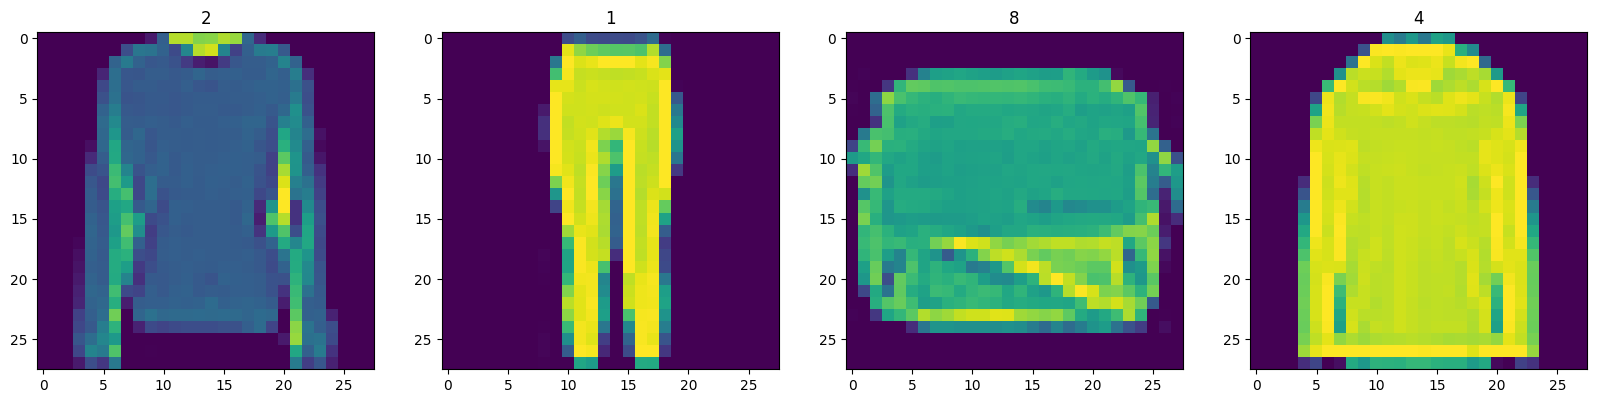

In [8]:
fig, ax = plt.subplots(ncols = 4, figsize = (20, 20))
for idx in range(4):
    batch = data_iterator.next()
    ax[idx].imshow(np.squeeze(batch['image']))
    ax[idx].title.set_text(batch['label'])

In [9]:
def scale_im(data):
    image = data['image']
    return image/255

In [1]:
print(ds)

NameError: name 'ds' is not defined

Data Pipeline 

In [10]:
ds = ds.map(scale_im)
ds = ds.cache()
ds = ds.shuffle(60000)
ds = ds.batch(128)
ds = ds.prefetch(64)

In [11]:
ds.as_numpy_iterator().next().shape

(128, 28, 28, 1)

Build The Generator Neural Network

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D

In [69]:
def build_generator():
    model = Sequential()
    model.add(Dense(7*7*128, input_dim = 128))
    model.add(LeakyReLU(0.2))
    model.add(Reshape((7,7,128)))
    
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding = "same"))
    model.add(LeakyReLU(0.2))
    
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding = "same"))
    model.add(LeakyReLU(0.2))
    
    model.add(Conv2D(128, 4, padding = "same"))
    model.add(LeakyReLU(0.2))
    
    model.add(Conv2D(128, 4, padding = "same"))
    model.add(LeakyReLU(0.2))

    model.add(Conv2D(1, 4, padding = "same", activation = "sigmoid"))
    
    return model

In [70]:
Generator = build_generator()
Generator.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 6272)              809088    
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 6272)              0         
                                                                 
 reshape_1 (Reshape)         (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d_2 (UpSamplin  (None, 14, 14, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 14, 14, 128)       409728    
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 14, 14, 128)       0         
                                                      

1/1 [==============================] - 0s 462ms/step


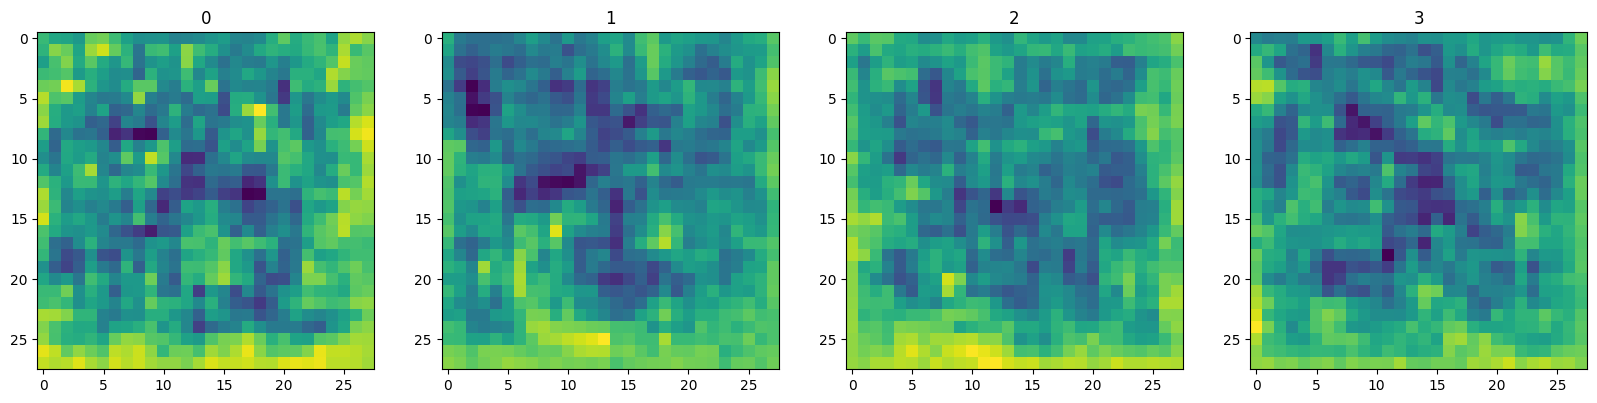

In [71]:
img = Generator.predict(np.random.randn(4, 128, 1))
fig, ax = plt.subplots(ncols = 4, figsize = (20, 20))
for idx, img in enumerate(img):
    ax[idx].imshow(np.squeeze(img))                         # remove 1 dimension in tensor
    ax[idx].title.set_text(idx)

In [16]:
img.shape

(28, 28, 1)

Build the Discriminator Neural Network

In [17]:
def build_discriminator():
    model = Sequential()
    
    model.add(Conv2D(32, 5, input_shape = (28, 28, 1)))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    model.add(Conv2D(64, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    model.add(Conv2D(128, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    model.add(Conv2D(256, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation ="sigmoid"))
    
    return model

In [18]:
Discriminator = build_discriminator()

In [19]:
Discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 24, 24, 32)        832       
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 24, 24, 32)        0         
                                                                 
 dropout (Dropout)           (None, 24, 24, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 20, 20, 64)        51264     
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 20, 20, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 20, 20, 64)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 16, 16, 128)      

In [20]:
img.shape

(28, 28, 1)

In [21]:
Discriminator.predict(np.expand_dims(img, 0))  # need batch dimension

1/1 [==============================] - 0s 195ms/step


array([[0.5137339]], dtype=float32)

Setup Optimizers and Lossess

In [22]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

In [23]:
g_opt = Adam(learning_rate=0.0001)
d_opt = Adam(learning_rate=0.00001)
g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()

Build Subclassed Model

In [24]:
from tensorflow.keras.models import Model

In [25]:
class FashionGAN(Model): 
    def __init__(self, generator, discriminator, *args, **kwargs):
        # Pass through args and kwargs to base class 
        super().__init__(*args, **kwargs)
        
        # Create attributes for gen and disc
        self.generator = generator 
        self.discriminator = discriminator 
        
    def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs): 
        # Compile with base class
        super().compile(*args, **kwargs)
        
        # Create attributes for losses and optimizers
        self.g_opt = g_opt
        self.d_opt = d_opt
        self.g_loss = g_loss
        self.d_loss = d_loss 

    def train_step(self, batch):
        # Get the data 
        real_images = batch
        fake_images = self.generator(tf.random.normal((128, 128, 1)), training=False)
        
        # Train the discriminator
        with tf.GradientTape() as d_tape: 
            # Pass the real and fake images to the discriminator model
            yhat_real = self.discriminator(real_images, training=True) 
            yhat_fake = self.discriminator(fake_images, training=True)
            yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)
            
            # Create labels for real and fakes images
            y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0)
            
            # Add some noise to the TRUE outputs
            noise_real = 0.15*tf.random.uniform(tf.shape(yhat_real))
            noise_fake = -0.15*tf.random.uniform(tf.shape(yhat_fake))
            y_realfake += tf.concat([noise_real, noise_fake], axis=0)
            
            # Calculate loss - BINARYCROSS 
            total_d_loss = self.d_loss(y_realfake, yhat_realfake)
            
        # Apply backpropagation - nn learn 
        dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables) 
        self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))
        
        # Train the generator 
        with tf.GradientTape() as g_tape: 
            # Generate some new images
            gen_images = self.generator(tf.random.normal((128,128,1)), training=True)
                                        
            # Create the predicted labels
            predicted_labels = self.discriminator(gen_images, training=False)
                                        
            # Calculate loss - trick to training to fake out the discriminator
            total_g_loss = self.g_loss(tf.zeros_like(predicted_labels), predicted_labels) 
            
        # Apply backprop
        ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))
        
        return {"d_loss":total_d_loss, "g_loss":total_g_loss}

In [26]:
fashgan = FashionGAN(Generator, Discriminator)

In [27]:
fashgan.compile(g_opt, d_opt, g_loss, d_loss)

In [28]:
hist = fashgan.fit(ds, epochs=2000)

Epoch 1/20
469/469 [==============================] - 2460s 5s/step - d_loss: 0.5273 - g_loss: 0.8652
Epoch 2/20
469/469 [==============================] - 2381s 5s/step - d_loss: 0.2817 - g_loss: 2.4803
Epoch 3/20
469/469 [==============================] - 4084s 9s/step - d_loss: 0.6914 - g_loss: 0.7633
Epoch 4/20
469/469 [==============================] - 31099s 66s/step - d_loss: 0.6902 - g_loss: 0.6905
Epoch 5/20
469/469 [==============================] - 2324s 5s/step - d_loss: 0.6834 - g_loss: 0.6947
Epoch 6/20
469/469 [==============================] - 2352s 5s/step - d_loss: 0.5271 - g_loss: 0.4896
Epoch 7/20
469/469 [==============================] - 2864s 6s/step - d_loss: 0.3156 - g_loss: 0.0298
Epoch 8/20
469/469 [==============================] - 2400s 5s/step - d_loss: 0.4864 - g_loss: 0.1057
Epoch 9/20
469/469 [==============================] - 2668s 6s/step - d_loss: 0.6992 - g_loss: 0.6393
Epoch 10/20
469/469 [==============================] - 2507s 5s/step - d_loss: 0

In [76]:
plt.suptitle('Loss')
plt.plot(hist.history['d_loss'], label='d_loss')
plt.plot(hist.history['g_loss'], label='g_loss')
plt.legend()
plt.show()

NameError: name 'hist' is not defined

<Figure size 640x480 with 0 Axes>

In [123]:
import os
from keras.models import load_model

weights_path = 'generatormodel.h5'

if os.path.exists(weights_path):
    try:
        Generator = load_model(weights_path)
        print("Weights loaded successfully.")
    except Exception as e:
        print(f"Error loading weights: {e}")
else:
    print(f"Weights file not found at {weights_path}.")


Weights loaded successfully.


In [122]:
import os

# Generator.load_weights(os.path.join('D:\GANs', 'generatormodel.h5'))
Generator.load_weights('generatormodel.h5')

In [129]:
imgs = Generator.predict(tf.random.normal((16, 256, 1)))

1/1 [==============================] - 0s 68ms/step


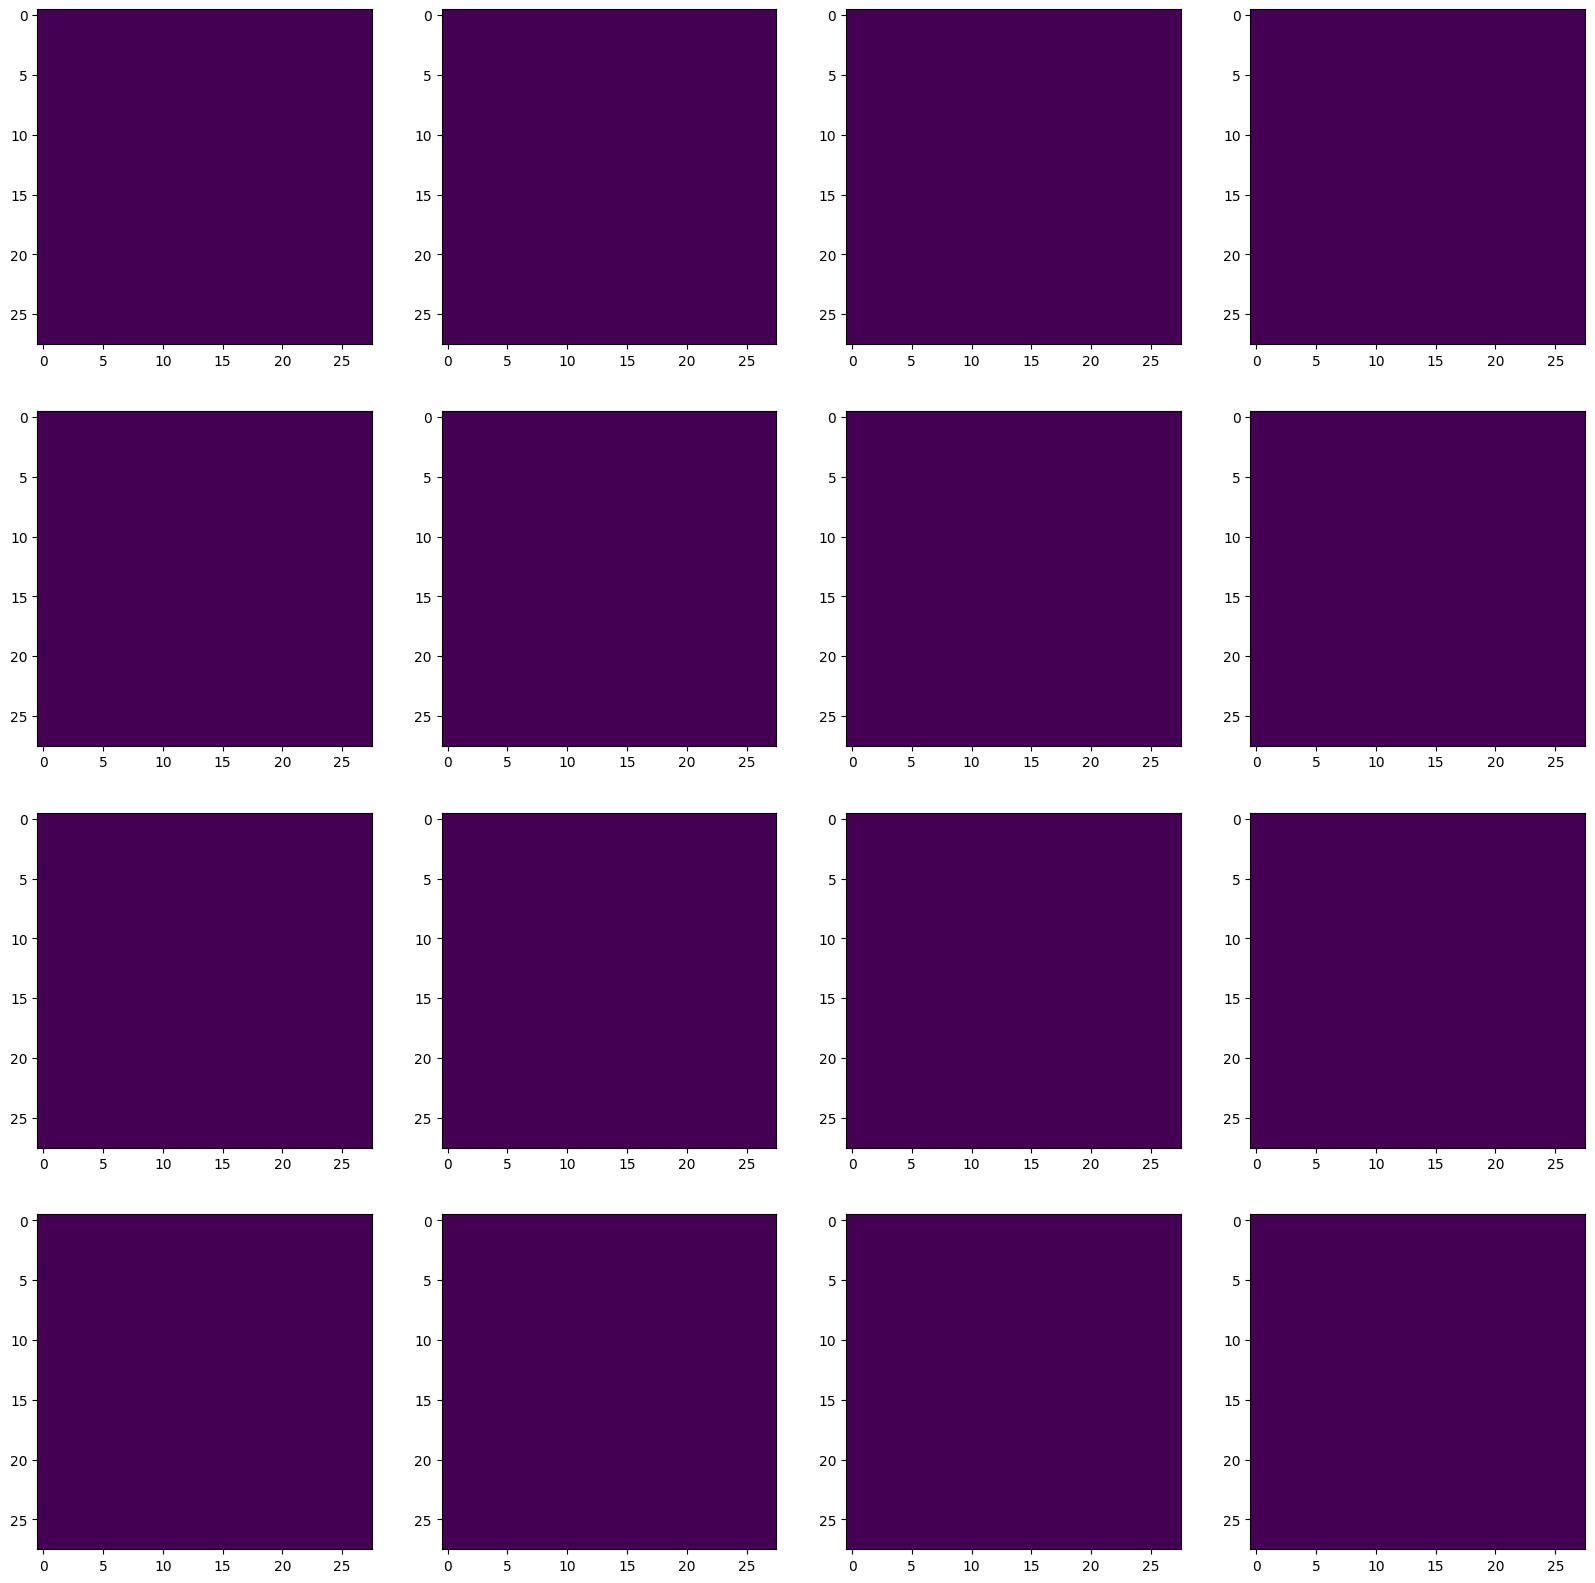

In [130]:
fig, ax = plt.subplots(4, 4, figsize = (20,20))
for i in range(4):
    for j in range(4):
        ax[i][j].imshow(imgs[((i+1)*(j+1)-1)])

In [117]:
Generator.save('generator.h5')
Discriminator.save('discriminator.h5')

c:\Python311\cv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
